In [4]:
import glob
import tifffile
import numpy as np
import lightgbm as lgb
import warnings
import tqdm

warnings.simplefilter('ignore')

In [5]:
train_path =  '/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/'
mask_path = '/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/mask/'

masks = glob.glob(f'{mask_path}/*')
trains = glob.glob(f'{train_path}/*')
masks.sort()
trains.sort()

In [6]:
def normalize(image):

    bands = image.shape[-1]
    
    for b in range(bands):
        
        band_min, band_max = (image[:,:,b].min(), image[:,:,b].max())

        image[:,:,b] = ((image[:,:,b]-band_min)/((band_max - band_min))) 

    
    return image

In [7]:
X = []
y = []
g = []

for i, (t, m) in enumerate(zip(trains, masks)):
    img = tifffile.imread(t).astype(np.float64)
    img = normalize(img)
    
    mask = tifffile.imread(m).astype(np.float64)
    X.append(img.reshape(-1,12))
    y.append(mask.reshape(-1))
    g.append(np.ones_like(mask.reshape(-1))*i)
    
X = np.vstack(X)
y = np.hstack(y)
g = np.hstack(g) 

In [8]:
X.shape

(1133572, 12)

In [9]:
lgb_params = {    
    'boosting_type':'gbdt',
    'num_leaves':31,
    'max_depth':-1,
    'n_estimators':300,
    'random_state':136
    }

In [10]:
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold

#gkfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=136)
gkfold = GroupKFold(n_splits=4)

models = []

for i, (train_idx, valid_idx) in enumerate(gkfold.split(X, y, g)):
    train_x = X[train_idx]
    train_y = y[train_idx]
    
    val_x = X[valid_idx]
    val_y = y[valid_idx]
    
    m = lgb.LGBMClassifier(**lgb_params)
    m.fit(train_x, train_y, 
         eval_metric='logloss',
         eval_set=[(val_x, val_y)],
         # early_stopping_rounds=10,
         # verbose=1,
         callbacks=[
            lgb.log_evaluation(100),
        ],
    )
    models.append(m)
    models.append(m)

[LightGBM] [Info] Number of positive: 81882, number of negative: 768528
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 850410, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.096285 -> initscore=-2.239198
[LightGBM] [Info] Start training from score -2.239198
[100]	valid_0's binary_logloss: 0.127455
[200]	valid_0's binary_logloss: 0.130094
[300]	valid_0's binary_logloss: 0.140921
[LightGBM] [Info] Number of positive: 78111, number of negative: 771836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] T

In [11]:
models

[LGBMClassifier(n_estimators=300, random_state=136),
 LGBMClassifier(n_estimators=300, random_state=136),
 LGBMClassifier(n_estimators=300, random_state=136),
 LGBMClassifier(n_estimators=300, random_state=136),
 LGBMClassifier(n_estimators=300, random_state=136),
 LGBMClassifier(n_estimators=300, random_state=136),
 LGBMClassifier(n_estimators=300, random_state=136),
 LGBMClassifier(n_estimators=300, random_state=136)]

In [12]:
test_path =  '/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/evaluation/'
test_mask_path = '/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/sample/'

masks = glob.glob(f'{test_mask_path}/*')
tests = glob.glob(f'{test_path}/*')
masks.sort()
tests.sort()

In [13]:
import os
if not os.path.isdir('output1'):
    os.mkdir('output1')

In [23]:
threshold = 0.6

for i, (m, t) in tqdm.tqdm(enumerate(zip(masks, tests))):
    basename = os.path.basename(m)
    output_file = f'output/{basename}'
    
    img = tifffile.imread(t).astype(np.float64)
    img = normalize(img)

    
    mask = tifffile.imread(m).astype(np.float64)
    
    X = img.reshape(-1, 12) 
    shape_mask = mask.shape
    
    pred = 0
    for model in models:
        pred = model.predict_proba(X) / len(models)

    pred_mask = np.argmax(pred, axis=1).astype(np.uint8)
    pred_mask = pred_mask.reshape(shape_mask[0], shape_mask[1])
    
    tifffile.imwrite(output_file, pred_mask)

2066it [00:17, 117.94it/s]


In [24]:
pred_mask.shape

(23, 23)

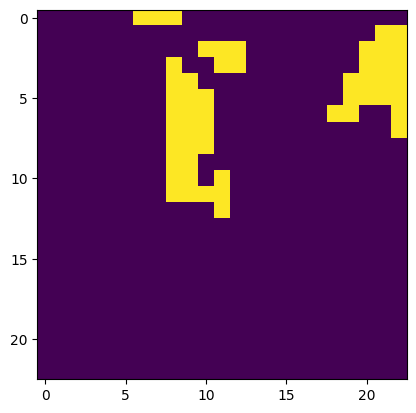

In [25]:
import matplotlib.pyplot as plt

plt.imshow(pred_mask)